In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import shap
from sklearn.model_selection import train_test_split
from windowshap import SlidingWindowSHAP, StationaryWindowSHAP, DynamicWindowSHAP
import timeit
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
shap.initjs()

c:\Users\ragam\.conda\envs\aioenv\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\ragam\.conda\envs\aioenv\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks,

# Synthetic data

This function generates a synthetic time series in which each feature sequence is generated using the sin() or cos() function. However, an anomaly interval is inserted at random into one of the feature sequences. If the feature with the anomaly is the first feature, the sample label is 1; otherwise, it is 0.

Data seperation to test and train

In [3]:
x, label = synthetic_data(n_samples=10000, n_steps=120, n_features=4)
train_x, test_x, train_y, test_y = train_test_split(x, label, test_size=0.3, random_state=0,
                                                    stratify=label)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=0,
                                                 stratify=train_y)

In [4]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(5600, 120, 4)
(3000, 120, 4)
(5600,)
(3000,)


# Prediction Model

In [5]:
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, GRU, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers

num_hidden = [70, 20]
num_neurons = 200
es_patience = 20
epochs = 40
num_output = 1
batch_size = 32
drop_rate = 0.3
reg_rate = 0.004

K.clear_session()
model = Sequential()
input_shape = (x.shape[1], x.shape[2])
model.add(GRU(units=num_neurons, activation='relu', input_shape=input_shape,
              recurrent_dropout=0.1, dropout=0.1))
for i in num_hidden:
    model.add(Dropout(drop_rate))
    model.add(Dense(units=i, activation='relu', kernel_regularizer=regularizers.l2(reg_rate)))
model.add(Dense(units=num_output, activation='sigmoid'))

# Creating and compiling model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=es_patience)

# Class weights
class_weights = {0:len(train_y)/(train_y==0).sum(),
                 1:len(train_y)/(train_y==1).sum()}

model.compile(optimizer=SGD(learning_rate=0.01, clipvalue=0.5), loss='binary_crossentropy',
              metrics=['accuracy'])
# model.build(input_shape)
model.summary()
train_history = model.fit(train_x, train_y, batch_size=batch_size,
                          epochs=epochs, verbose=2,
                          validation_data=(val_x, val_y),
                          class_weight=class_weights,
                          callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 200)               123600    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 70)                14070     
                                                                 
 dropout_1 (Dropout)         (None, 70)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                1420      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 139,111
Trainable params: 139,111
Non-trai

In [6]:
from sklearn.metrics import roc_auc_score, accuracy_score
print(roc_auc_score(test_y, model.predict(test_x)))
print(accuracy_score(test_y, np.round(model.predict(test_x))))

94/94 [==============================] - 6s 54ms/step
1.0
94/94 [==============================] - 5s 50ms/step
1.0


In [7]:
test_y[20:30]

array([0., 0., 1., 0., 0., 0., 1., 0., 1., 1.])

## SHAP interpretation

In [8]:
num_background = 50
num_test = 28
background_data, test_data = train_x[:num_background], test_x[num_test:num_test+2]

## 1- Stationary WindowSHAP

In [9]:
tic = timeit.default_timer()
ts_phi_1 = np.zeros((len(test_data),test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    window_len = 20
    gtw = StationaryWindowSHAP(model, window_len, B_ts=background_data, test_ts=test_data[i:i+1], model_type='lstm')
    ts_phi_1[i,:,:] = gtw.shap_values()
print('Total time: ' + str(timeit.default_timer()-tic))

2/2 [==============================] - 0s 38ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

3275/3275 [==============================] - 155s 47ms/step


100%|██████████| 1/1 [05:13<00:00, 313.46s/it]

2/2 [==============================] - 0s 33ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

3275/3275 [==============================] - 205s 63ms/step


100%|██████████| 1/1 [05:59<00:00, 359.88s/it]

Total time: 673.9603219


## 2- Sliding WindowSHAP

In [10]:
tic = timeit.default_timer()
ts_phi_2 = np.zeros((len(test_data),test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    window_len = 20
    stride = 10
    gtw = SlidingWindowSHAP(model, stride, window_len, background_data, test_data[i:i+1], model_type='lstm')
    ts_phi_2[i,:,:] = gtw.shap_values()
print('Total time: ' + str(timeit.default_timer()-tic))

2/2 [==============================] - 0s 37ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 4s 57ms/step


100%|██████████| 1/1 [00:04<00:00,  4.95s/it]

2/2 [==============================] - 0s 38ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 4s 57ms/step


100%|██████████| 1/1 [00:05<00:00,  5.09s/it]

2/2 [==============================] - 0s 38ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 4s 56ms/step


100%|██████████| 1/1 [00:04<00:00,  4.90s/it]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 46ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 4s 58ms/step


100%|██████████| 1/1 [00:05<00:00,  5.06s/it]

2/2 [==============================] - 0s 40ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 4s 58ms/step


100%|██████████| 1/1 [00:05<00:00,  5.03s/it]

2/2 [==============================] - 0s 44ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 4s 57ms/step


100%|██████████| 1/1 [00:05<00:00,  5.00s/it]

2/2 [==============================] - 0s 37ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 3s 50ms/step


100%|██████████| 1/1 [00:04<00:00,  4.48s/it]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 38ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 3s 45ms/step


100%|██████████| 1/1 [00:04<00:00,  4.24s/it]

2/2 [==============================] - 0s 35ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 3s 44ms/step


100%|██████████| 1/1 [00:04<00:00,  4.18s/it]

2/2 [==============================] - 0s 34ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 3s 45ms/step


100%|██████████| 1/1 [00:04<00:00,  4.29s/it]

2/2 [==============================] - 0s 34ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 3s 44ms/step


100%|██████████| 1/1 [00:04<00:00,  4.11s/it]

2/2 [==============================] - 0s 37ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 3s 43ms/step


100%|██████████| 1/1 [00:04<00:00,  4.04s/it]

2/2 [==============================] - 0s 36ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 3s 42ms/step


100%|██████████| 1/1 [00:03<00:00,  3.96s/it]

2/2 [==============================] - 0s 35ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 3s 42ms/step


100%|██████████| 1/1 [00:04<00:00,  4.08s/it]

2/2 [==============================] - 0s 39ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 3s 43ms/step


100%|██████████| 1/1 [00:04<00:00,  4.09s/it]

2/2 [==============================] - 0s 39ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 3s 44ms/step


100%|██████████| 1/1 [00:04<00:00,  4.19s/it]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 36ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 3s 44ms/step


100%|██████████| 1/1 [00:04<00:00,  4.07s/it]

2/2 [==============================] - 0s 35ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 3s 43ms/step


100%|██████████| 1/1 [00:04<00:00,  4.17s/it]

2/2 [==============================] - 0s 37ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 3s 43ms/step


100%|██████████| 1/1 [00:04<00:00,  4.10s/it]

2/2 [==============================] - 0s 35ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 3s 45ms/step


100%|██████████| 1/1 [00:04<00:00,  4.19s/it]

2/2 [==============================] - 0s 32ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 3s 43ms/step


100%|██████████| 1/1 [00:04<00:00,  4.01s/it]

2/2 [==============================] - 0s 35ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 3s 44ms/step


100%|██████████| 1/1 [00:04<00:00,  4.12s/it]

Total time: 100.76919529999986


## 3- Dynamic WindowSHAP

In [11]:
tic = timeit.default_timer()
ts_phi_3 = np.zeros((len(test_data),test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    delta = 0.3
    n_w = 8
    btw = DynamicWindowSHAP(model, delta, n_w, background_data, test_data[i:i+1], model_type='lstm')
    ts_phi_3[i,:,:] = btw.shap_values()
print('Total time: ' + str(timeit.default_timer()-tic))

2/2 [==============================] - 0s 38ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

13/13 [==============================] - 1s 49ms/step


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


2/2 [==============================] - 0s 37ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

16/16 [==============================] - 1s 44ms/step


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

2/2 [==============================] - 0s 36ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

19/19 [==============================] - 1s 51ms/step


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

2/2 [==============================] - 0s 35ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

22/22 [==============================] - 1s 52ms/step


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 48ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

29/29 [==============================] - 1s 45ms/step


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

2/2 [==============================] - 0s 39ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

41/41 [==============================] - 2s 46ms/step


100%|██████████| 1/1 [00:02<00:00,  2.73s/it]

2/2 [==============================] - 0s 36ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

3241/3241 [==============================] - 158s 49ms/step


100%|██████████| 1/1 [03:24<00:00, 204.99s/it]

2/2 [==============================] - 0s 37ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

13/13 [==============================] - 1s 62ms/step


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 52ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

16/16 [==============================] - 1s 65ms/step


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


2/2 [==============================] - 0s 100ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

22/22 [==============================] - 1s 67ms/step


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


2/2 [==============================] - 0s 52ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

29/29 [==============================] - 2s 69ms/step


100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


2/2 [==============================] - 0s 61ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

35/35 [==============================] - 2s 70ms/step


100%|██████████| 1/1 [00:03<00:00,  3.23s/it]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 52ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

3197/3197 [==============================] - 202s 63ms/step


100%|██████████| 1/1 [04:06<00:00, 246.50s/it]

Total time: 475.65823420000015


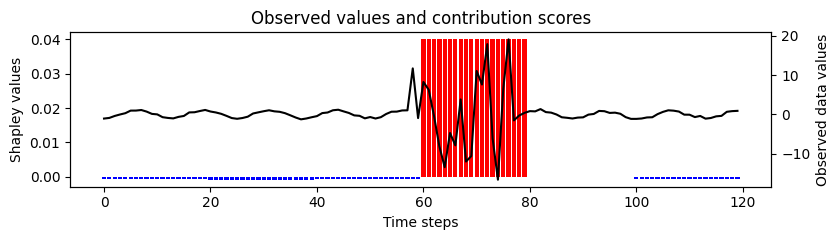

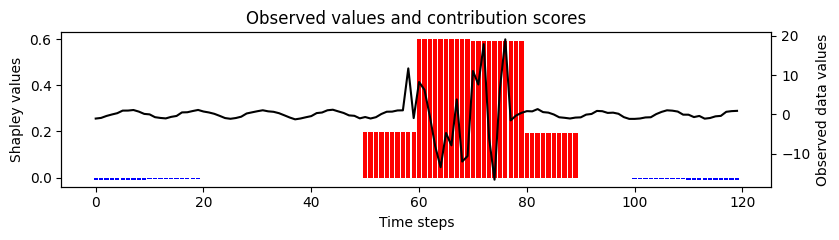

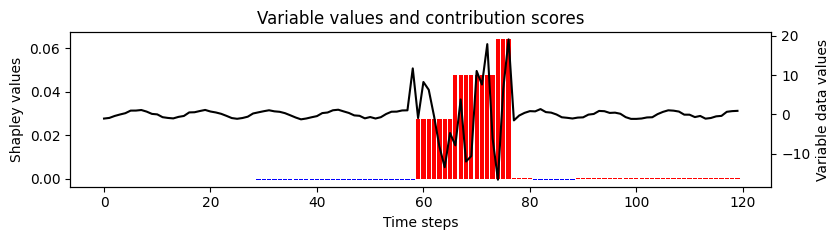

In [14]:
from util import heat_map

var = 0
phi_index = 0 
heat_map(start=0, stop=120, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_1[phi_index, :, var], var_name='Observed', plot_type='bar')
heat_map(start=0, stop=120, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_2[phi_index, :, var], var_name='Observed', plot_type='bar')
heat_map(start=0, stop=120, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_3[phi_index, :, var], var_name='Variable', plot_type='bar')

In [15]:
a = [[1,2,3],[4,5,6],[6,5,4],[3,8,9]]
a = np.array(a)
a.shape

(4, 3)

In [16]:
a = a.reshape(-1,1)
a.shape

(12, 1)